# Model Selection for CNN Using Keras and MADlib on CIFAR-10

E2E classification example using MADlib calling a Keras CNN for different hyperparameters and model architectures on the CIFAR-10 dataset.

The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
https://www.cs.toronto.edu/~kriz/cifar.html

## Table of contents 

<a href="#setup">0. Setup</a>

<a href="#load_dataset">1. Load dataset into table</a>

<a href="#distr">2. Setup distribution rules and call preprocessor</a>

<a href="#arch">3. Define and load model architectures</a>

<a href="#mst">4. Define and load model selection tuples</a>

<a href="#train">5. Train</a>

<a href="#plot">6. Plot results</a>

<a href="#predict">7. Inference</a>

<a id="setup"></a>
# 0. Setup

In [1]:
%load_ext sql

In [2]:
# Greenplum Database 5.x on GCP - via tunnel
%sql postgresql://gpadmin@localhost:8000/cifar_places
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

In [3]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


version
"MADlib version: 1.17-dev, git revision: rc/1.16-rc1-95-gc62dfe7, cmake configuration time: Tue Mar 17 16:53:55 UTC 2020, build type: RelWithDebInfo, build system: Linux-2.6.32-754.6.3.el6.x86_64, C compiler: gcc 4.4.7, C++ compiler: g++ 4.4.7"


Import libraries

In [4]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
import os

Using TensorFlow backend.


Others needed in this workbook

In [5]:
import pandas as pd
import numpy as np
import sys
import os
from matplotlib import pyplot as plt

<a id="load_dataset"></a>
# 1.  Load dataset into table

PXF can be used to load image data into Greenplum database.

But for this demo, we will get the dataset from Keras and use the script called madlib_image_loader.py located at https://github.com/apache/madlib-site/tree/asf-site/community-artifacts/Deep-learning .

If the script is not in the same folder as the notebook, you can use the following lines to import it.

In [6]:
import sys
sys.path.insert(1, '/Users/fmcquillan/workspace/madlib-site/community-artifacts/Deep-learning')
from madlib_image_loader import ImageLoader, DbCredentials

# Specify database credentials, for connecting to db
db_creds = DbCredentials(db_name='cifar_places',
                         user='gpadmin',
                         host='localhost',
                         port='8000',
                         password='')

#db_creds = DbCredentials(db_name='cifar_places',
#                         user='fmcquillan',
#                         host='localhost',
#                         port='5432',
#                         password='')

# Initialize ImageLoader (increase num_workers to run faster)
iloader = ImageLoader(num_workers=5, db_creds=db_creds)

Load dataset into tables

In [ ]:
# Load dataset into np array
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

%sql DROP TABLE IF EXISTS cifar10_train, cifar10_val;

# Save images to temporary directories and load into database
iloader.load_dataset_from_np(x_train, y_train, 'cifar10_train', append=False)
iloader.load_dataset_from_np(x_test, y_test, 'cifar10_val', append=False)

In [6]:
%sql SELECT COUNT(*) FROM cifar10_train;

1 rows affected.


count
50000


In [7]:
%sql SELECT COUNT(*) FROM cifar10_val;

1 rows affected.


count
10000


<a id="distr"></a>
# 2.  Setup distribution rules and call preprocessor

In this example we will train on 4 VMs with 4 segments/VM and 4 GPUs/VM (i.e., 16 workers).

First get the GPU configuration in the cluster using the MADlib helper function `gpu_configuration`:

In [8]:
%%sql
DROP TABLE IF EXISTS host_gpu_mapping_tf;
SELECT * FROM madlib.gpu_configuration('host_gpu_mapping_tf');
SELECT * FROM host_gpu_mapping_tf ORDER BY hostname, gpu_descr;

Done.
1 rows affected.
20 rows affected.


hostname,gpu_descr
gpsix0,"device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
gpsix0,"device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:05.0, compute capability: 6.0"
gpsix0,"device: 2, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:06.0, compute capability: 6.0"
gpsix0,"device: 3, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:07.0, compute capability: 6.0"
gpsix1,"device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
gpsix1,"device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:05.0, compute capability: 6.0"
gpsix1,"device: 2, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:06.0, compute capability: 6.0"
gpsix1,"device: 3, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:07.0, compute capability: 6.0"
gpsix2,"device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
gpsix2,"device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:05.0, compute capability: 6.0"


Review the Greenplum segments in the `gp_segment_configuration` table:

In [9]:
%%sql
SELECT * FROM gp_segment_configuration ORDER BY dbid;

21 rows affected.


dbid,content,role,preferred_role,mode,status,port,hostname,address,datadir
1,-1,p,p,n,u,5432,gpsix0,gpsix0,/data/master/gpseg-1
2,0,p,p,n,u,40000,gpsix0,gpsix0,/data/primary0/gpseg0
3,1,p,p,n,u,40001,gpsix0,gpsix0,/data/primary1/gpseg1
4,2,p,p,n,u,40002,gpsix0,gpsix0,/data/primary2/gpseg2
5,3,p,p,n,u,40003,gpsix0,gpsix0,/data/primary3/gpseg3
6,4,p,p,n,u,40000,gpsix1,gpsix1,/data/primary0/gpseg4
7,5,p,p,n,u,40001,gpsix1,gpsix1,/data/primary1/gpseg5
8,6,p,p,n,u,40002,gpsix1,gpsix1,/data/primary2/gpseg6
9,7,p,p,n,u,40003,gpsix1,gpsix1,/data/primary3/gpseg7
10,8,p,p,n,u,40000,gpsix2,gpsix2,/data/primary0/gpseg8


Now JOIN the above 2 tables to build up various distribution rules, depending on your needs.

We build distribution rules table for 4 VMs:

In [10]:
%%sql
DROP TABLE IF EXISTS segments_to_use_4VMs;
CREATE TABLE segments_to_use_4VMs AS
  SELECT DISTINCT dbid, hostname FROM gp_segment_configuration JOIN host_gpu_mapping_tf USING (hostname)
  WHERE role='p' AND content>=0 AND hostname!='gpsix4';
SELECT * FROM segments_to_use_4VMs ORDER BY hostname, dbid;

Done.
16 rows affected.
16 rows affected.


dbid,hostname
2,gpsix0
3,gpsix0
4,gpsix0
5,gpsix0
6,gpsix1
7,gpsix1
8,gpsix1
9,gpsix1
10,gpsix2
11,gpsix2


Run the preprocessor to generate the packed output table on the segments we want to use for training:

In [11]:
%%sql
DROP TABLE IF EXISTS cifar10_train_packed, cifar10_train_packed_summary;

SELECT madlib.training_preprocessor_dl('cifar10_train',        -- Source table
                                       'cifar10_train_packed', -- Output table
                                       'y',                    -- Dependent variable
                                       'x',                    -- Independent variable
                                        NULL,                  -- Buffer size
                                        256.0,                 -- Normalizing constant
                                        NULL,                  -- Number of classes
                                       'segments_to_use_4VMs'  -- Distribution rules
                                        );

SELECT __dist_key__, independent_var_shape, dependent_var_shape, buffer_id FROM cifar10_train_packed ORDER BY __dist_key__;

Done.
1 rows affected.
16 rows affected.


__dist_key__,independent_var_shape,dependent_var_shape,buffer_id
0,"[3125, 32, 32, 3]","[3125, 10]",1
1,"[3125, 32, 32, 3]","[3125, 10]",4
2,"[3125, 32, 32, 3]","[3125, 10]",9
3,"[3125, 32, 32, 3]","[3125, 10]",7
4,"[3125, 32, 32, 3]","[3125, 10]",14
7,"[3125, 32, 32, 3]","[3125, 10]",11
9,"[3125, 32, 32, 3]","[3125, 10]",13
12,"[3125, 32, 32, 3]","[3125, 10]",15
14,"[3125, 32, 32, 3]","[3125, 10]",6
19,"[3125, 32, 32, 3]","[3125, 10]",12


In [12]:
%%sql
SELECT * FROM cifar10_train_packed_summary;

1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes,distribution_rules,__internal_gpu_config__
cifar10_train,cifar10_train_packed,y,x,smallint,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",3125,256.0,10,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]"


Same for validation dataset:

In [13]:
%%sql
DROP TABLE IF EXISTS cifar10_val_packed, cifar10_val_packed_summary;

SELECT madlib.validation_preprocessor_dl('cifar10_val',          -- Source table
                                         'cifar10_val_packed',   -- Output table
                                         'y',                    -- Dependent variable
                                         'x',                    -- Independent variable
                                         'cifar10_train_packed', -- From training preprocessor step
                                         NULL,                   -- Buffer size
                                         'segments_to_use_4VMs'  -- Distribution rules
                                          ); 

SELECT __dist_key__, independent_var_shape, dependent_var_shape, buffer_id FROM cifar10_val_packed ORDER BY __dist_key__;

Done.
1 rows affected.
16 rows affected.


__dist_key__,independent_var_shape,dependent_var_shape,buffer_id
0,"[625, 32, 32, 3]","[625, 10]",1
1,"[625, 32, 32, 3]","[625, 10]",4
2,"[625, 32, 32, 3]","[625, 10]",9
3,"[625, 32, 32, 3]","[625, 10]",7
4,"[625, 32, 32, 3]","[625, 10]",14
7,"[625, 32, 32, 3]","[625, 10]",11
9,"[625, 32, 32, 3]","[625, 10]",13
12,"[625, 32, 32, 3]","[625, 10]",15
14,"[625, 32, 32, 3]","[625, 10]",6
19,"[625, 32, 32, 3]","[625, 10]",12


In [14]:
%%sql
SELECT * FROM cifar10_val_packed_summary;

1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes,distribution_rules,__internal_gpu_config__
cifar10_val,cifar10_val_packed,y,x,smallint,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",625,256.0,10,"[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]"


<a id="arch"></a>
# 3. Define and load model architectures

Model architecture from https://keras.io/examples/cifar10_cnn/

In [15]:
num_classes = 10

In [18]:
model1 = Sequential()

model1.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

model1.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_______________________

In [19]:
model1.to_json()

'{"class_name": "Sequential", "keras_version": "2.2.4", "config": {"layers": [{"class_name": "Conv2D", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 1.0, "seed": null, "mode": "fan_avg"}}, "name": "conv2d_1", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "linear", "trainable": true, "data_format": "channels_last", "filters": 32, "padding": "same", "strides": [1, 1], "dilation_rate": [1, 1], "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "batch_input_shape": [null, 32, 32, 3], "use_bias": true, "activity_regularizer": null, "kernel_size": [3, 3]}}, {"class_name": "Activation", "config": {"activation": "relu", "trainable": true, "name": "activation_1"}}, {"class_name": "Conv2D", "config": {"kernel_constraint": null, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale":

Model architecture from https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [20]:
model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.2))
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.3))
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D((2, 2)))
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

model2.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        18496     
________

In [21]:
model2.to_json()

'{"class_name": "Sequential", "keras_version": "2.2.4", "config": {"layers": [{"class_name": "Conv2D", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 2.0, "seed": null, "mode": "fan_in"}}, "name": "conv2d_5", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "data_format": "channels_last", "filters": 32, "padding": "same", "strides": [1, 1], "dilation_rate": [1, 1], "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "batch_input_shape": [null, 32, 32, 3], "use_bias": true, "activity_regularizer": null, "kernel_size": [3, 3]}}, {"class_name": "BatchNormalization", "config": {"beta_constraint": null, "gamma_initializer": {"class_name": "Ones", "config": {}}, "moving_mean_initializer": {"class_name": "Zeros", "config": {}}, "name": "batch_normalization_1", "epsilon": 0.001, "trainable": true, "moving

Another model architecture from https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

In [22]:
model3 = Sequential()

model3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
model3.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.2))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.3))
model3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model3.add(MaxPooling2D((2, 2)))
model3.add(Dropout(0.4))
model3.add(Flatten())
model3.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model3.add(Dropout(0.5))
model3.add(Dense(10, activation='softmax'))

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [23]:
model3.to_json()

'{"class_name": "Sequential", "keras_version": "2.2.4", "config": {"layers": [{"class_name": "Conv2D", "config": {"kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 2.0, "seed": null, "mode": "fan_in"}}, "name": "conv2d_11", "kernel_constraint": null, "bias_regularizer": null, "bias_constraint": null, "dtype": "float32", "activation": "relu", "trainable": true, "data_format": "channels_last", "filters": 32, "padding": "same", "strides": [1, 1], "dilation_rate": [1, 1], "kernel_regularizer": null, "bias_initializer": {"class_name": "Zeros", "config": {}}, "batch_input_shape": [null, 32, 32, 3], "use_bias": true, "activity_regularizer": null, "kernel_size": [3, 3]}}, {"class_name": "Conv2D", "config": {"kernel_constraint": null, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"distribution": "uniform", "scale": 2.0, "seed": null, "mode": "fan_in"}}, "name": "conv2d_12", "bias_regularizer": null, "bias_constraint": nul

Load into model architecture table using psycopg2

In [24]:
import psycopg2 as p2
#conn = p2.connect('postgresql://gpadmin@35.239.240.26:5432/madlib')
#conn = p2.connect('postgresql://fmcquillan@localhost:5432/madlib')
conn = p2.connect('postgresql://gpadmin@localhost:8000/cifar_places')
cur = conn.cursor()

%sql DROP TABLE IF EXISTS model_arch_library;
query = "SELECT madlib.load_keras_model('model_arch_library', %s, NULL, %s)"
cur.execute(query,[model1.to_json(), "CNN from Keras docs for CIFAR-10"])
conn.commit()

query = "SELECT madlib.load_keras_model('model_arch_library', %s, NULL, %s)"
cur.execute(query,[model2.to_json(), "CNN from Jason Brownlee blog post"])
conn.commit()

query = "SELECT madlib.load_keras_model('model_arch_library', %s, NULL, %s)"
cur.execute(query,[model3.to_json(), "CNN from Jason Brownlee blog post - no batch normalization"])
conn.commit()

# check model loaded OK
%sql SELECT model_id, name FROM model_arch_library ORDER BY model_id;

Done.


[]

3 rows affected.


model_id,name
1,CNN from Keras docs for CIFAR-10
2,CNN from Jason Brownlee blog post
3,CNN from Jason Brownlee blog post - no batch normalization


<a id="mst"></a>
# 4.  Define and load model selection tuples

Select the model(s) from the model architecture table that you want to run, along with the compile and fit parameters. Permutations for grid search will be created for the set of model selection parameters will be loaded:

In [25]:
%%sql
DROP TABLE IF EXISTS mst_table, mst_table_summary;

SELECT madlib.load_model_selection_table('model_arch_library', -- model architecture table
                                         'mst_table',          -- model selection table output
                                          ARRAY[1,2],          -- model ids from model architecture table
                                          ARRAY[               -- compile params   
                                              $$loss='categorical_crossentropy',optimizer='rmsprop(lr=0.0001, decay=1e-6)',metrics=['accuracy']$$,
                                              $$loss='categorical_crossentropy',optimizer='rmsprop(lr=0.001, decay=1e-6)',metrics=['accuracy']$$,
                                              $$loss='categorical_crossentropy',optimizer='adam(lr=0.0001)',metrics=['accuracy']$$,
                                              $$loss='categorical_crossentropy',optimizer='adam(lr=0.001)',metrics=['accuracy']$$
                                          ],
                                          ARRAY[                -- fit params
                                              $$batch_size=64,epochs=5$$, 
                                              $$batch_size=128,epochs=5$$
                                          ]
                                         );
                                  
SELECT * FROM mst_table ORDER BY mst_key;

Done.
1 rows affected.
16 rows affected.


mst_key,model_id,compile_params,fit_params
1,1,"loss='categorical_crossentropy',optimizer='adam(lr=0.0001)',metrics=['accuracy']","batch_size=64,epochs=5"
2,1,"loss='categorical_crossentropy',optimizer='adam(lr=0.0001)',metrics=['accuracy']","batch_size=128,epochs=5"
3,1,"loss='categorical_crossentropy',optimizer='rmsprop(lr=0.0001, decay=1e-6)',metrics=['accuracy']","batch_size=64,epochs=5"
4,1,"loss='categorical_crossentropy',optimizer='rmsprop(lr=0.0001, decay=1e-6)',metrics=['accuracy']","batch_size=128,epochs=5"
5,1,"loss='categorical_crossentropy',optimizer='rmsprop(lr=0.001, decay=1e-6)',metrics=['accuracy']","batch_size=64,epochs=5"
6,1,"loss='categorical_crossentropy',optimizer='rmsprop(lr=0.001, decay=1e-6)',metrics=['accuracy']","batch_size=128,epochs=5"
7,1,"loss='categorical_crossentropy',optimizer='adam(lr=0.001)',metrics=['accuracy']","batch_size=64,epochs=5"
8,1,"loss='categorical_crossentropy',optimizer='adam(lr=0.001)',metrics=['accuracy']","batch_size=128,epochs=5"
9,2,"loss='categorical_crossentropy',optimizer='adam(lr=0.0001)',metrics=['accuracy']","batch_size=64,epochs=5"
10,2,"loss='categorical_crossentropy',optimizer='adam(lr=0.0001)',metrics=['accuracy']","batch_size=128,epochs=5"


This is the name of the model architecture table that corresponds to the model selection table:

In [26]:
%%sql
SELECT * FROM mst_table_summary;

1 rows affected.


model_arch_table
model_arch_library


<a id="train"></a>
# 5.  Train
Train multiple models:

In [6]:
%%sql
DROP TABLE IF EXISTS cifar10_multi_model, cifar10_multi_model_summary, cifar10_multi_model_info;

SELECT madlib.madlib_keras_fit_multiple_model('cifar10_train_packed',    -- source_table
                                              'cifar10_multi_model',     -- model_output_table
                                              'mst_table',               -- model_selection_table
                                               10,                       -- num_iterations
                                               TRUE,                     -- use gpus
                                              'cifar10_val_packed',      -- validation dataset
                                               1                         -- metrics compute frequency
                                             );

Done.
1 rows affected.


madlib_keras_fit_multiple_model
""


View the model summary:

In [27]:
%%sql
SELECT * FROM cifar10_multi_model_summary;

1 rows affected.


source_table,validation_table,model,model_info,dependent_varname,independent_varname,model_arch_table,num_iterations,metrics_compute_frequency,warm_start,name,description,start_training_time,end_training_time,madlib_version,num_classes,class_values,dependent_vartype,normalizing_const,metrics_iters
cifar10_train_packed,cifar10_val_packed,cifar10_multi_model,cifar10_multi_model_info,y,x,model_arch_library,10,1,False,None,None,2020-03-24 22:19:52.670763,2020-03-24 22:48:08.984136,1.17-dev,10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",smallint,256.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"


View performance of each model:

In [28]:
%%sql
SELECT * FROM cifar10_multi_model_info ORDER BY validation_metrics_final DESC;

16 rows affected.


mst_key,model_id,compile_params,fit_params,model_type,model_size,metrics_elapsed_time,metrics_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss
16,2,"loss='categorical_crossentropy',optimizer='adam(lr=0.001)',metrics=['accuracy']","batch_size=128,epochs=5",madlib_keras,2159.70019531,"[167.736330986023, 333.425091981888, 500.695713996887, 668.302587985992, 837.287312984467, 1006.06942605972, 1176.67615294456, 1346.787348032, 1518.12181210518, 1690.67020988464]",[u'accuracy'],0.957840025425,0.121589891613,"[0.769860029220581, 0.824000000953674, 0.873139977455139, 0.89300000667572, 0.895640015602112, 0.906700015068054, 0.931919991970062, 0.942839980125427, 0.940620005130768, 0.957840025424957]","[0.66564804315567, 0.511175155639648, 0.367111206054688, 0.307224303483963, 0.300335615873337, 0.268611431121826, 0.196494549512863, 0.165175542235374, 0.172968357801437, 0.12158989161253]",0.836000025272,0.582142531872,"[0.742699980735779, 0.790499985218048, 0.808600008487701, 0.818700015544891, 0.822000026702881, 0.821699976921082, 0.831499993801117, 0.83569997549057, 0.83050000667572, 0.836000025272369]","[0.731135308742523, 0.629253566265106, 0.586650609970093, 0.561055064201355, 0.600637912750244, 0.576708614826202, 0.567015171051025, 0.560995817184448, 0.577787160873413, 0.582142531871796]"
14,2,"loss='categorical_crossentropy',optimizer='rmsprop(lr=0.001, decay=1e-6)',metrics=['accuracy']","batch_size=128,epochs=5",madlib_keras,2159.70019531,"[161.545518875122, 327.271953105927, 493.721956014633, 662.059704065323, 830.583410024643, 999.47811293602, 1170.08322310448, 1339.875207901, 1511.35515999794, 1682.88088107109]",[u'accuracy'],0.942120015621,0.166348025203,"[0.768679976463318, 0.83459997177124, 0.865559995174408, 0.88782000541687, 0.900080025196075, 0.898840010166168, 0.929400026798248, 0.926339983940125, 0.941559970378876, 0.942120015621185]","[0.659707903862, 0.479000419378281, 0.394761860370636, 0.320042163133621, 0.286971271038055, 0.289592266082764, 0.203219100832939, 0.216255784034729, 0.16890250146389, 0.166348025202751]",0.834399998188,0.587312161922,"[0.751600027084351, 0.794099986553192, 0.81029999256134, 0.816500008106232, 0.825600028038025, 0.819199979305267, 0.825200021266937, 0.833199977874756, 0.840300023555756, 0.834399998188019]","[0.725527286529541, 0.628955543041229, 0.603530406951904, 0.578122794628143, 0.565659284591675, 0.587804615497589, 0.575832903385162, 0.586635053157806, 0.558215022087097, 0.587312161922455]"
15,2,"loss='categorical_crossentropy',optimizer='adam(lr=0.001)',metrics=['accuracy']","batch_size=64,epochs=5",madlib_keras,2159.70019531,"[159.585074901581, 325.616278886795, 492.079638957977, 660.141077041626, 828.460551977158, 997.682931900024, 1168.2648499012, 1338.03905391693, 1509.35755109787, 1680.94471693039]",[u'accuracy'],0.957620024681,0.123506456614,"[0.780160009860992, 0.830079972743988, 0.864920020103455, 0.880159974098206, 0.907660007476807, 0.922760009765625, 0.930760025978088, 0.94489997625351, 0.953960001468658, 0.957620024681091]","[0.640457689762115, 0.484953910112381, 0.392606198787689, 0.350569307804108, 0.266773730516434, 0.223709508776665, 0.199900239706039, 0.160074487328529, 0.134055703878403, 0.123506456613541]",0.833199977875,0.585961103439,"[0.747500002384186, 0.790600001811981, 0.805899977684021, 0.807099997997284, 0.818899989128113, 0.814999997615814, 0.821300029754639, 0.827600002288818, 0.830999970436096, 0.833199977874756]","[0.733774244785309, 0.621092319488525, 0.600942432880402, 0.603525757789612, 0.582037806510925, 0.593123733997345, 0.593485474586487, 0.585796058177948, 0.578036189079285, 0.585961103439331]"
13,2,"loss='categorical_crossentropy',optimizer='rmsprop(lr=0.001, decay=1e-6)',metrics=['accuracy']","batch_size=64,epochs=5",madlib_keras,2159.70019531,"[164.595175027847, 330.364078044891, 497.435774087906, 665.216387033463, 833.77009892463

<a id="plot"></a>
# 6. Plot results

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import defaultdict
import pandas as pd
plt.rcParams.update({'font.size': 12})
pd.set_option('display.max_colwidth', -1)

Training data

16 rows affected.
1 rows affected.


<IPython.core.display.Javascript object>


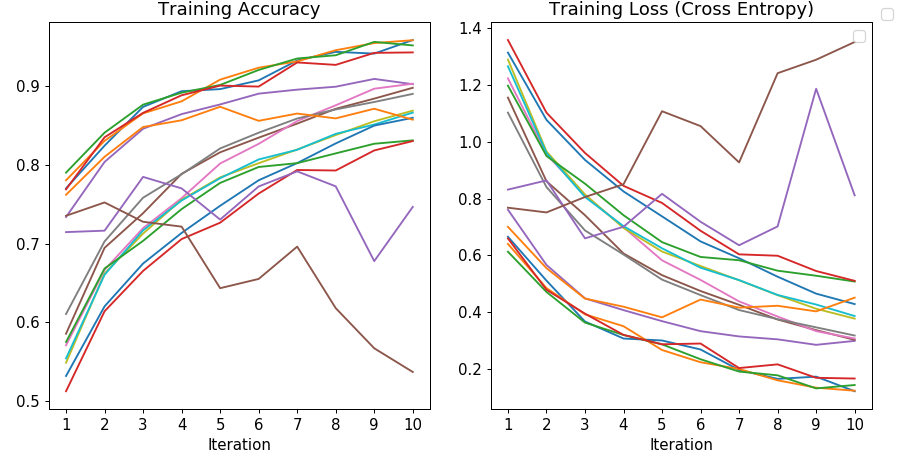

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


In [7]:
df_results = %sql SELECT * FROM cifar10_multi_model_info ORDER BY training_loss_final ASC LIMIT 100;
df_results = df_results.DataFrame()

df_summary = %sql SELECT * FROM cifar10_multi_model_summary;
df_summary = df_summary.DataFrame()

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Iteration')
#ax_metric.set_ylabel('Accuracy')
ax_metric.set_title('Training Accuracy')

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Iteration')
#ax_loss.set_ylabel('Cross Entropy Loss')
ax_loss.set_title('Training Loss (Cross Entropy)')

iters = df_summary['metrics_iters'][0]

for mst_key in df_results['mst_key']:
    df_output_info = %sql SELECT training_metrics,training_loss FROM cifar10_multi_model_info WHERE mst_key = $mst_key
    df_output_info = df_output_info.DataFrame()
    training_metrics = df_output_info['training_metrics'][0]
    training_loss = df_output_info['training_loss'][0]

    #ax_metric.plot(iters, training_metrics, label=mst_key, marker='o')
    #ax_metric.plot(iters, training_metrics, marker='o')
    ax_metric.plot(iters, training_metrics)
    
    #ax_loss.plot(iters, training_loss, label=mst_key, marker='o')
    #ax_loss.plot(iters, training_loss, marker='o')
    ax_loss.plot(iters, training_loss)

plt.legend();
# fig.savefig('./lc_keras_fit.png', dpi = 300)

Validation data

16 rows affected.
1 rows affected.


<IPython.core.display.Javascript object>


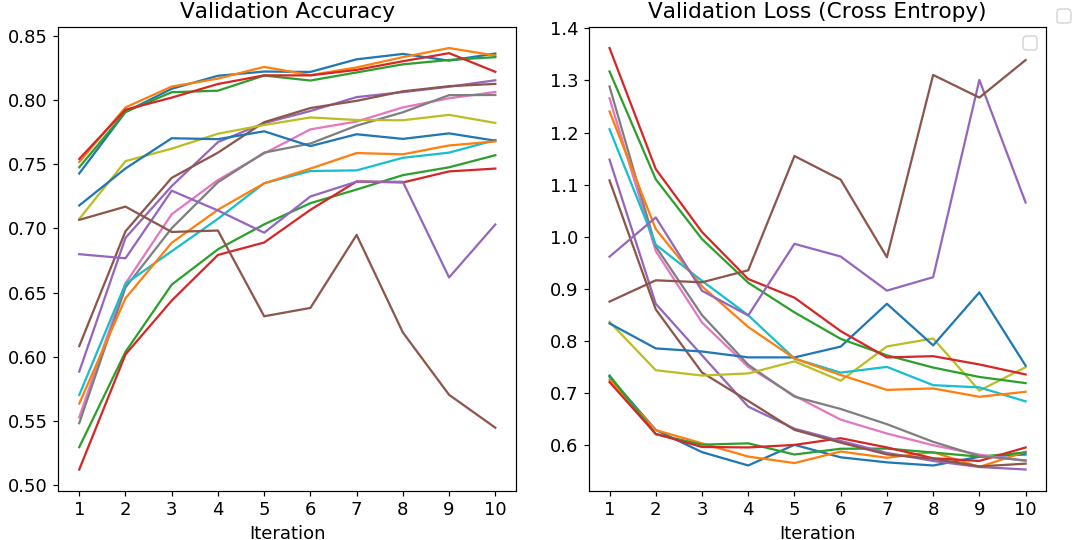

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


In [8]:
df_results = %sql SELECT * FROM cifar10_multi_model_info ORDER BY validation_metrics_final DESC LIMIT 100;
df_results = df_results.DataFrame()

df_summary = %sql SELECT * FROM cifar10_multi_model_summary;
df_summary = df_summary.DataFrame()

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Iteration')
#ax_metric.set_ylabel('Accuracy')
ax_metric.set_title('Validation Accuracy')

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Iteration')
#ax_loss.set_ylabel('Cross Entropy Loss')
ax_loss.set_title('Validation Loss (Cross Entropy)')

iters = df_summary['metrics_iters'][0]

for mst_key in df_results['mst_key']:
    df_output_info = %sql SELECT validation_metrics,validation_loss FROM cifar10_multi_model_info WHERE mst_key = $mst_key
    df_output_info = df_output_info.DataFrame()
    validation_metrics = df_output_info['validation_metrics'][0]
    validation_loss = df_output_info['validation_loss'][0]
    
    #ax_metric.plot(iters, validation_metrics, label=mst_key, marker='o')
    ax_metric.plot(iters, validation_metrics)
    
    #ax_loss.plot(iters, validation_loss, label=mst_key, marker='o')
    ax_loss.plot(iters, validation_loss)

plt.legend();
# fig.savefig('./lc_keras_fit.png', dpi = 300)

Plot training and validation curves together

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


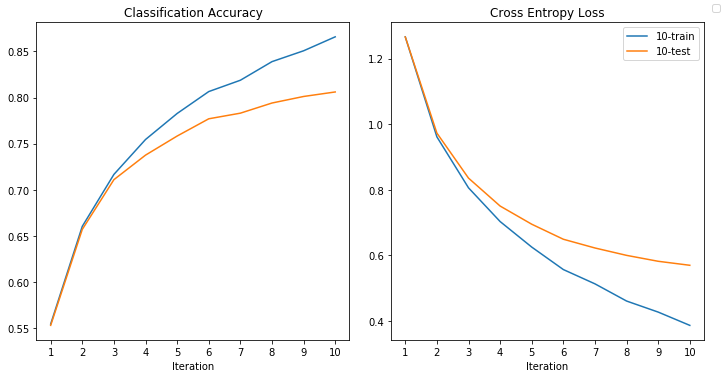

In [40]:
# mst tuple(s) to plot
mst_key_to_plot = 10
df_results = %sql SELECT * FROM cifar10_multi_model_info WHERE mst_key = $mst_key_to_plot;
df_results = df_results.DataFrame()

df_summary = %sql SELECT * FROM cifar10_multi_model_summary;
df_summary = df_summary.DataFrame()

#set up plots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
fig.legend(ncol=4)
fig.tight_layout()

ax_metric = axs[0]
ax_loss = axs[1]

ax_metric.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_metric.set_xlabel('Iteration')
#ax_metric.set_ylabel('Accuracy')
ax_metric.set_title('Classification Accuracy')

ax_loss.xaxis.set_major_locator(MaxNLocator(integer=True))
ax_loss.set_xlabel('Iteration')
#ax_loss.set_ylabel('Loss')
ax_loss.set_title('Cross Entropy Loss')

iters = df_summary['metrics_iters'][0]

for mst_key in df_results['mst_key']:
    
    #train
    df_output_info = %sql SELECT training_metrics,training_loss FROM cifar10_multi_model_info WHERE mst_key = $mst_key
    df_output_info = df_output_info.DataFrame()
    training_metrics = df_output_info['training_metrics'][0]
    training_loss = df_output_info['training_loss'][0]
    
    #test
    df_output_info = %sql SELECT validation_metrics,validation_loss FROM cifar10_multi_model_info WHERE mst_key = $mst_key
    df_output_info = df_output_info.DataFrame()
    validation_metrics = df_output_info['validation_metrics'][0]
    validation_loss = df_output_info['validation_loss'][0]
    
    label_train = str(mst_key) + '-train'
    #ax_metric.plot(iters, training_metrics, label=label_train, marker='x')
    #ax_loss.plot(iters, training_loss, label=label_train, marker='x')
    ax_metric.plot(iters, training_metrics, label=label_train)
    ax_loss.plot(iters, training_loss, label=label_train)
    
    label_test = str(mst_key) + '-test'
    #ax_metric.plot(iters, validation_metrics, label=label_test, marker='o')
    #ax_loss.plot(iters, validation_loss, label=label_test, marker='o')
    ax_metric.plot(iters, validation_metrics, label=label_test)
    ax_loss.plot(iters, validation_loss, label=label_test)

plt.legend();
# fig.savefig('./lc_keras_fit.png', dpi = 300)

<a id="predict"></a>
# 7. Inference

## 7a. Run predict on the whole validation dataset

Pick a reasonable model from the previous run.

In [10]:
%%sql
SELECT * FROM cifar10_multi_model_info WHERE mst_key=10;

1 rows affected.


mst_key,model_id,compile_params,fit_params,model_type,model_size,metrics_elapsed_time,metrics_type,training_metrics_final,training_loss_final,training_metrics,training_loss,validation_metrics_final,validation_loss_final,validation_metrics,validation_loss
10,2,"loss='categorical_crossentropy',optimizer='adam(lr=0.0001)',metrics=['accuracy']","batch_size=128,epochs=5",madlib_keras,2159.70019531,"[157.675038099289, 323.760583877563, 489.999938964844, 658.165150880814, 826.338515996933, 995.962205886841, 1166.19140601158, 1335.88773202896, 1507.49120998383, 1679.03732204437]",[u'accuracy'],0.865880012512,0.386452704668,"[0.554459989070892, 0.660399973392487, 0.71670001745224, 0.754540026187897, 0.78276002407074, 0.806519985198975, 0.81879997253418, 0.83898001909256, 0.850740015506744, 0.865880012512207]","[1.26610136032104, 0.961102485656738, 0.805769920349121, 0.702959299087524, 0.625120878219604, 0.556592226028442, 0.513025283813477, 0.460623860359192, 0.426946371793747, 0.386452704668045]",0.806100010872,0.569638252258,"[0.552999973297119, 0.657100021839142, 0.711000025272369, 0.737600028514862, 0.758300006389618, 0.77700001001358, 0.783100008964539, 0.794099986553192, 0.801199972629547, 0.806100010871887]","[1.26569390296936, 0.972574234008789, 0.835387766361237, 0.750236749649048, 0.694831550121307, 0.648999333381653, 0.622370600700378, 0.599871814250946, 0.581832528114319, 0.569638252258301]"


In [11]:
%%sql
DROP TABLE IF EXISTS cifar10_val_predict;

SELECT madlib.madlib_keras_predict('cifar10_multi_model', -- model
                                   'cifar10_val',         -- test_table
                                   'id',                  -- id column
                                   'x',                   -- independent var
                                   'cifar10_val_predict', -- output table
                                    'response',           -- prediction type
                                    TRUE,                 -- use gpus
                                    10                    -- mst_key to use
                                   );

SELECT * FROM cifar10_val_predict ORDER BY id LIMIT 5;

Done.
1 rows affected.
5 rows affected.


id,estimated_y
1,3
2,8
3,8
4,0
5,6


Count missclassifications

In [12]:
%%sql
SELECT COUNT(*) FROM cifar10_val_predict JOIN cifar10_val USING (id) 
WHERE cifar10_val_predict.estimated_y != cifar10_val.y;

1 rows affected.


count
1939


Accuracy

In [13]:
%%sql
SELECT round(count(*)*100.0/10000.0,2) as test_accuracy_percent from
    (select cifar10_val.y as actual, cifar10_val_predict.estimated_y as predicted
     from cifar10_val_predict inner join cifar10_val
     on cifar10_val.id=cifar10_val_predict.id) q
WHERE q.actual=q.predicted;

1 rows affected.


test_accuracy_percent
80.61


## 7b. Select a random image from the validation dataset and run predict

Label map

In [14]:
label_names = {
    0 :"airplane",
    1 :"automobile",
    2 :"bird",
    3 :"cat",
    4 :"deer",
    5 :"dog",
    6 :"frog",
    7 :"horse",
    8 :"ship",
    9 :"truck"
}

Pick a random image

In [21]:
%%sql
DROP TABLE IF EXISTS cifar10_val_random;
CREATE TABLE cifar10_val_random AS
    SELECT * FROM cifar10_val ORDER BY random() LIMIT 1;

Done.
1 rows affected.


[]

Predict

In [22]:
%%sql
DROP TABLE IF EXISTS cifar10_val_random_predict;

SELECT madlib.madlib_keras_predict('cifar10_multi_model', -- model
                                   'cifar10_val_random',  -- test_table
                                   'id',                  -- id column
                                   'x',                   -- independent var
                                   'cifar10_val_random_predict', -- output table
                                    'prob',               -- prediction type
                                    TRUE,                 -- use gpus
                                    10                    -- mst_key to use
                                   );

SELECT * FROM cifar10_val_random_predict;

Done.
1 rows affected.
1 rows affected.


id,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9
4032,2.626629e-06,2.7014737e-08,0.0022699283,2.0414376e-05,0.99757725,1.5412388e-05,1.7638637e-05,9.5042335e-05,1.4481008e-06,5.417283e-08


Format output and display

In [23]:
%%sql
DROP TABLE IF EXISTS cifar10_val_random_predict_array, cifar10_val_random_predict_array_summary;
SELECT madlib.cols2vec(
    'cifar10_val_random_predict',
    'cifar10_val_random_predict_array',
    '*',
    'id'
);
select * from cifar10_val_random_predict_array;

Done.
1 rows affected.
1 rows affected.


feature_vector
"[2.626629e-06, 2.7014737e-08, 0.0022699283, 2.0414376e-05, 0.99757725, 1.5412388e-05, 1.7638637e-05, 9.5042335e-05, 1.4481008e-06, 5.417283e-08]"


1 rows affected.


1 rows affected.
 
deer 0.99757725
bird 0.0022699283
horse 9.5042335e-05


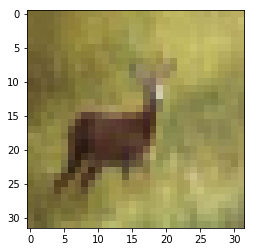

In [24]:
x = %sql SELECT x FROM cifar10_val_random;
x = x.DataFrame().to_numpy()
import numpy as np
from matplotlib.pyplot import imshow
%matplotlib inline
x_np = np.array(x[0][0], dtype=np.uint8)
imshow(x_np);

x = %sql SELECT * FROM cifar10_val_random_predict_array;
x = x.DataFrame().to_numpy()
x = np.array(x[0][0])
top_3_prob_label_indices = x.argsort()[-3:][::-1]
print (" ");
for index in top_3_prob_label_indices:
    print (label_names[index], x[index])